##✍ В этом модуле вы будете работать с датасетом, в котором содержатся сведения о 515 000 отзывов на отели Европы. Модель, которую вы будете обучать, должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных. Изученные нами навыки разведывательного анализа помогут улучшить модель.

In [1]:
import numpy as np 
import pandas as pd 
from datetime import date

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder


# для нормализации, стандартизации
from sklearn import preprocessing

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Загружаем тесты для отбра признаков
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
!pip freeze > requirements.txt

### 1. Подгружаем данные

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = 'C:/Users/d3en/OneDrive/Рабочий стол/dataScience/IDE/PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle/data_3/kaggle'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

Первоначальная версия датасета содержит 17 полей со следующей информацией:

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review— отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыве;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

Тренировочный датасет состоит из 386803 строк и 17 столбцов, тестовый из 128935 строк и 16 столбцов.Пропущенные значения: lat — географическая широта отеля и lng — географическая долгота отеля в обоих дата сетах.Файлы находятся в ворматах float64(4 столбца), int64(5 столбцов), object(8 столбцов). В тестовом отсутствует целевой столбец 'reviewer_score'(float64).

## 2. Создание столбцов и обработка признаков

* Сам процесс создания и тестирования модели занимает всего четыре строчки кода. В качестве алгоритма мы будем использовать популярный и довольно мощный алгоритм RandomForestRegressor. Он реализован в библиотеке sklearn.

* Для корректной работы все данные в датафрейме, который мы будем использовать при обучении модели, должны быть в числовых форматах int или float.

* Есть ещё одно ограничение: в столбцах не должно быть пропущенных значений. Вместо каждого пропущенного значения нам нужно будет вычислить и поместить в ячейку максимально близкое к реальности значение.

* Таким образом, чтобы код, отвечающий за обучение модели, заработал, мы должны использовать в нём датафрейм, содержащий только количественные признаки и не содержащий пропущенных значений.

In [7]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotel = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [8]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

#### 2.1 Cоздадим признаки страна и город

In [9]:
# Функция для извлечения города

def sity(sity_name):
    sity_name = sity_name.split(' ')
    return sity_name[-2]
# Функция для извлечения страны

def country(country_name):
    country_name = country_name.split(' ')
    return country_name[-1]

In [10]:
#  Создаем признак город, в случае с Лондоном заменям значения в ручную с помошью lambda функции.
hotel['Сity'] = hotel['hotel_address'].apply(sity)
hotel['Сity'] = hotel['Сity'].apply(lambda x: 'London' if x =='United' else x)

# Аналогично поступаем с признаком страна.
hotel['Country'] = hotel['hotel_address'].apply(country)
hotel['Country'] = hotel['Country'].apply(lambda x: 'UK' if x== 'Kingdom' else x)

#### 2.2 Заполним пропуски в столбцах с координатами ('lat', 'lng').

In [11]:
# В пропуски добавляем среднее значение координат. Не совсем правильно я считаю, в свободное время постараюсь подтянуть сюда информацию из внешних источников.
hotel['lat'] = hotel['lat'].fillna(hotel['lat'].mean())
hotel['lng'] = hotel['lng'].fillna(hotel['lng'].mean())

In [12]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [13]:
# кодируем признак городс с помощью  метода LabelEncode, страну не кодируем, так как количество городов совпвадает с количеством стран

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
hotel['Сity'] = LabelEncoder().fit_transform(hotel['Сity'])

hotel.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,Сity,Country
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,3,Italy
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,0,Netherlands
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,1,Spain
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0,3,Italy
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0,0,Netherlands


#### 2.3 Выделим из 'reviewer_nationality' 10 чаще встрчающихся, а остальные закодируем как 'Other', затем закодируем признак с помощью  LabelEncoder

In [14]:
#Оставим только 10 наиболее активных национальностей
popul_nationalities= hotel['reviewer_nationality'].value_counts().nlargest(10).index
hotel['reviewer_nationality'] = hotel['reviewer_nationality'].apply(lambda x:x if x in popul_nationalities else 'Other')

In [15]:
# закодирeм признак reviewer_nationality с помощью LabelEncoder
hotel['reviewer_nationality'] = LabelEncoder().fit_transform(hotel['reviewer_nationality'])
hotel.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,Сity,Country
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,8,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,3,Italy
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,10,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,0,Netherlands
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,10,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,1,Spain


#### 2.4 Создание новых признаков, на основе даты отзыва

In [17]:
# Преобразуем в datatime
hotel['review_date'] = pd.to_datetime(hotel['review_date'])

# Создаем маску для признака, относительно сезона
mask12 = (hotel['review_date'].dt.month ==12) 
mask1= (hotel['review_date'].dt.month <3)
mask2 = (hotel['review_date'].dt.month >2) & (hotel['review_date'].dt.month <6)
mask3 = (hotel['review_date'].dt.month >5) & (hotel['review_date'].dt.month <9)
mask4 = (hotel['review_date'].dt.month >8) & (hotel['review_date'].dt.month <12)

# Присваиваем номер месяца, и помещаем в колонку соответствующую сезону
hotel['winter'] = hotel[mask1]['review_date'].dt.month
hotel['winter'] = hotel[mask12]['review_date'].dt.month
hotel['string'] = hotel[mask2]['review_date'].dt.month
hotel['summer'] = hotel[mask3]['review_date'].dt.month
hotel['autumn'] = hotel[mask4]['review_date'].dt.month

In [18]:
# Заполняем пропуски
hotel['winter'] = hotel['winter'].fillna(0)
hotel['string'] = hotel['string'].fillna(0)
hotel['summer'] = hotel['summer'].fillna(0)
hotel['autumn'] = hotel['autumn'].fillna(0)

In [19]:
# Удаляем колонку типа datatime
hotel.drop(['review_date'], inplace=True, axis=1)

#### 2.5 Работа с отзывами
##### Используя библиотеку для обработки текстовой речи, мы попытаемся извлечь из отзывов дополнительные значимые признаки.

In [20]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

analyz = SentimentIntensityAnalyzer()

# проводим анализ текста с помощью SentimentIntensityAnalyzer()
hotel['review_neg'] = hotel['negative_review'].apply(lambda x: analyz.polarity_scores(x))
hotel['review_pos'] = hotel['positive_review'].apply(lambda x: analyz.polarity_scores(x))

# результаты помещаем в data
hotel.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(hotel['review_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
hotel.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(hotel['review_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

hotel.head(5)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\d3en\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,review_neg,review_pos,n_neg,n_neu,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,8,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,"{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...","{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...",0.129,0.747,0.125,-0.0554,0.000,0.671,0.329,0.9615
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,10,No tissue paper box was present at the room,10,5018,No Positive,0,...,"{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...","{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...",0.216,0.784,0.000,-0.2960,0.379,0.000,0.621,0.3400
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,10,Pillows,3,351,Nice welcoming and service,5,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...",0.000,1.000,0.000,0.0000,0.000,0.260,0.740,0.6908
3,Piazza Della Repubblica 17 Central Station 201...,241,9.1,Hotel Principe Di Savoia,9,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,...,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'comp...",1.000,0.000,0.000,-0.7096,0.000,0.621,0.379,0.9153
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,9.1,Hotel Esther a,8,No Negative,0,4687,Lovely hotel v welcoming staff,7,...,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.23, 'pos': 0.77, 'compou...",1.000,0.000,0.000,-0.7096,0.000,0.230,0.770,0.7717


In [21]:
# отбор нечисловых колонок

df_non_numeric = hotel.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

['hotel_address' 'hotel_name' 'negative_review' 'positive_review' 'tags'
 'days_since_review' 'Country' 'review_neg' 'review_pos']


In [22]:
# убираем признаки которые еще не успели обработать,
object_columns = [s for s in hotel.columns if hotel[s].dtypes == 'object']
hotel.drop(object_columns, axis = 1, inplace=True)

In [23]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   reviewer_nationality                        515738 non-null  int32  
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

<AxesSubplot:>

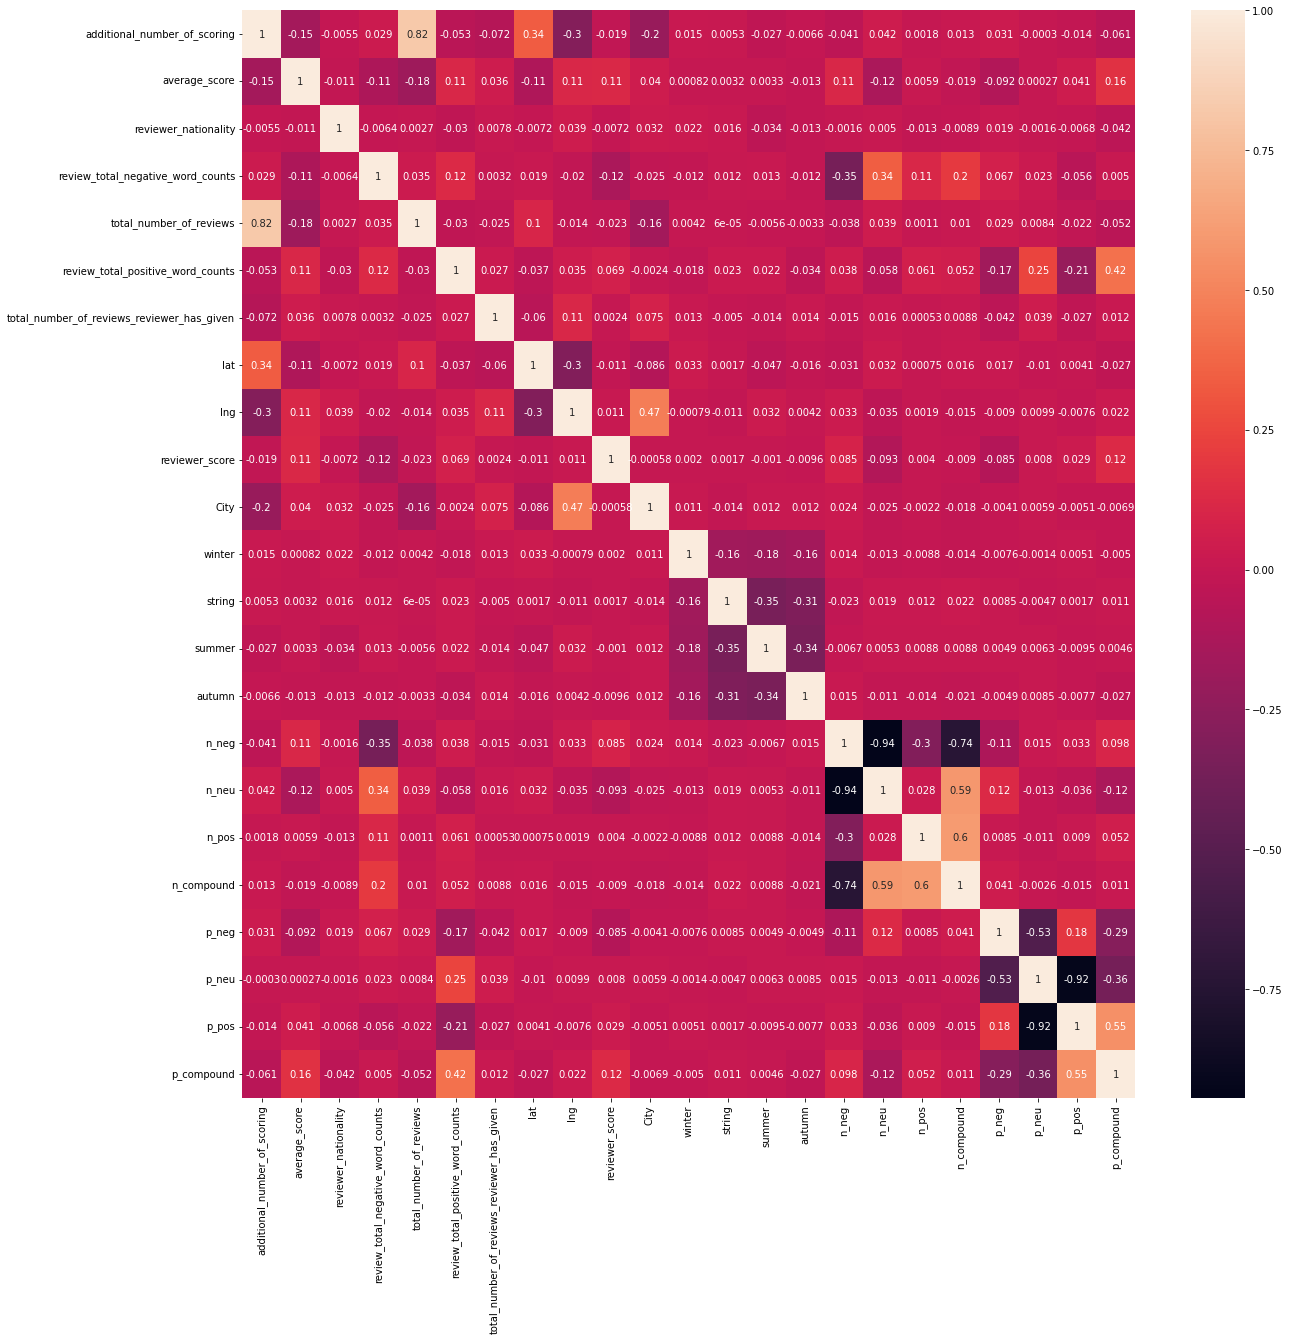

In [24]:
# строим матрицу корреляции
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(hotel.drop(['sample'], axis=1).corr(), annot=True)

In [25]:
#### Очистим датасет от сильно коррелирующих признаков, на основании информации из матрицы корреляций.
hotel.drop(['p_neu', 'n_neg', 'n_neu', 'additional_number_of_scoring'], axis = 1, inplace=True) 

<AxesSubplot:>

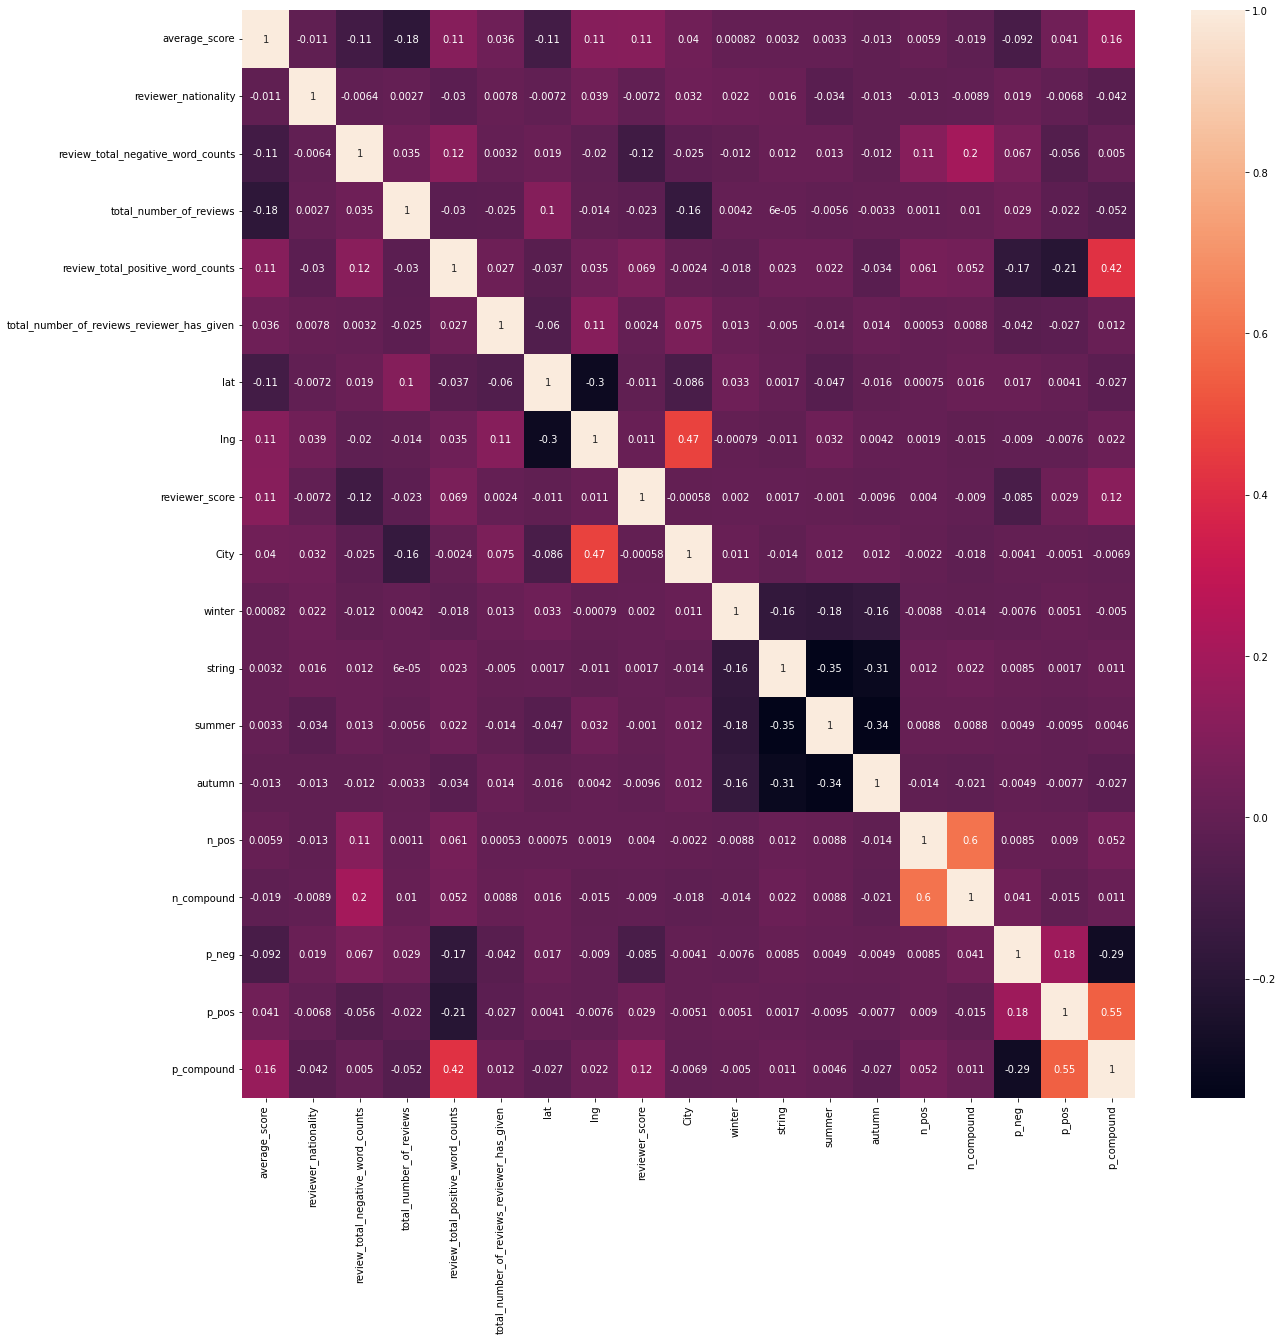

In [26]:
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(hotel.drop(['sample'], axis=1).corr(), annot=True)

In [27]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   reviewer_nationality                        515738 non-null  int32  
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

In [28]:
# непрерывные признаки
num_cols = [
     'average_score', 'review_total_negative_word_counts',
     'total_number_of_reviews', 
     'review_total_positive_word_counts', 
     'total_number_of_reviews_reviewer_has_given',
      'lng',
     'n_pos','n_compound', 'p_neg', 'p_pos', 'p_compound'
    
     ] # 'n_neg','n_neu', !!'p_neu'

# категориальные признаки
cat_cols = ['reviewer_nationality',
     'Сity',
     'string', 
     'summer', 'autumn','winter', 
          ]

In [29]:
X = hotel.drop(['reviewer_score'], axis = 1)  
y = hotel['reviewer_score'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

<AxesSubplot:>

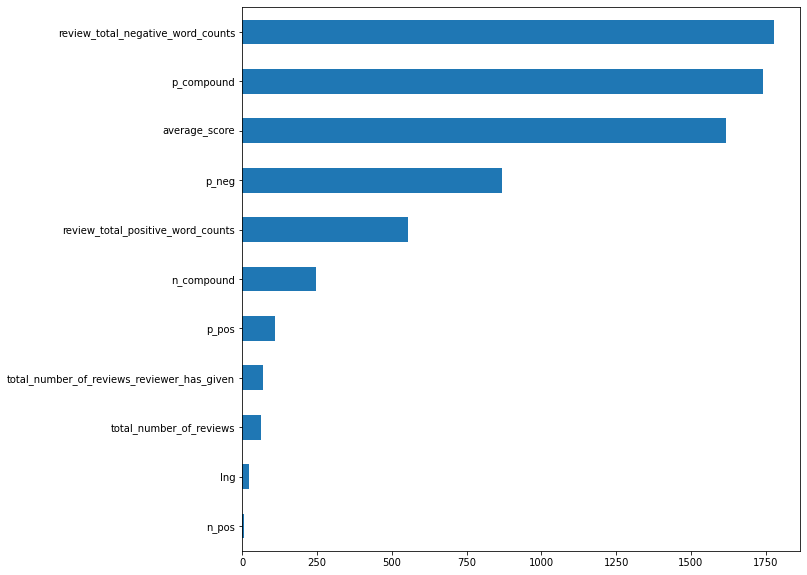

In [30]:
from sklearn.feature_selection import f_classif # anova

plt.rcParams['figure.figsize'] = (10,10)
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

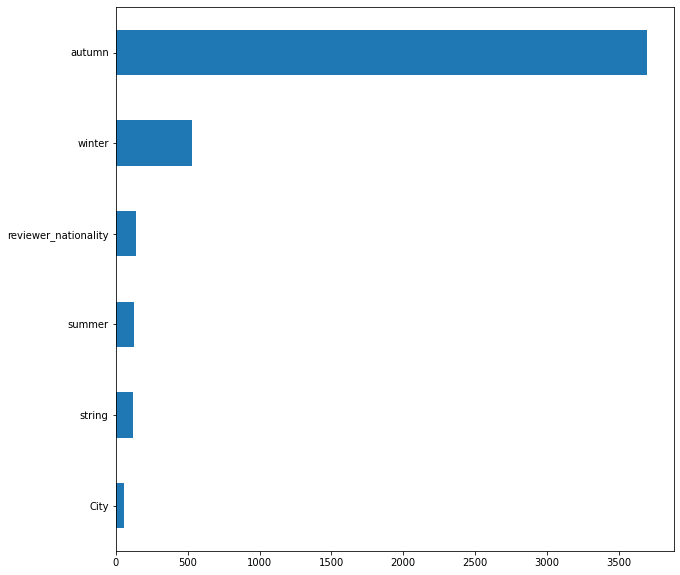

In [31]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

### 3. СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛИ

Сам процесс создания и тестирования модели занимает всего четыре строчки кода. В качестве алгоритма мы будем использовать популярный и довольно мощный алгоритм RandomForestRegressor. Он реализован в библиотеке sklearn.

In [32]:
train_data = hotel.query('sample == 1').drop(['sample'], axis=1)
test_data = hotel.query('sample == 0').drop(['sample'], axis=1)

X = train_data.drop(['reviewer_score'], axis=1)
y = train_data.reviewer_score.values

In [33]:
# разделяем тренинговый датасет: 75% на обучение, 25% на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [34]:
# проверяем размерности получившихся датасетов
train_data.shape, test_data.shape, X.shape, X_train.shape, X_test.shape

((386803, 19), (128935, 19), (386803, 18), (290102, 18), (96701, 18))

In [35]:
# создаём модель
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)

# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train) 

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))
# MAPE: 0.126147665683826

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s


MAPE: 0.12575704607627303


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished


###4. ОЦЕНКА КАЧЕСТВА МОДЕЛИ

In [36]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [37]:
predict_submission = regr.predict(test_data)
predict_submission

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.3s finished


array([8.615, 7.795, 8.69 , ..., 8.454, 9.53 , 7.437])

In [38]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('final_submission_2.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.615,488440
1,7.795,274649
2,8.690,374688
3,9.795,404352
4,9.542,451596
5,9.130,302161
6,7.790,317079
7,7.480,13963
8,8.513,159785
9,7.895,195089
